In [1]:
import sys
sys.path.append('../reconstruct_missing_data')

from data_loading import find_data_files, load_data_set, get_anomalies, create_missing_mask, split_and_scale_data

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import xarray as xr
from pathlib import Path
from json import dump, load
import os

In [2]:
# Check current working directory:
print(os.getcwd())

/gxfs_work1/geomar/smomw511/GitHub/MarcoLandtHayen/reconstruct_missing_data/notebooks


In [4]:
# Look for slp real world data:
find_data_files(data_path='../data/', data_source_name='raw')

[PosixPath('../data/raw/pres.sfc.mon.mean.nc')]

In [9]:
# Open data set:
slp_dataset=xr.open_dataset("../data/raw/pres.sfc.mon.mean.nc")

# Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
slp_fields = (
    slp_dataset.pres
    .sel(time=slice('1948-01-01', '2022-12-01'))
)

# Compute monthly climatology (here 1980 - 2009) for whole world:
slp_climatology_fields = (
    slp_dataset.pres
    .sel(time=slice('1980-01-01','2009-12-01'))
    .groupby("time.month")
    .mean("time")
)

# Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
slp_anomaly_fields = slp_fields.groupby("time.month") - slp_climatology_fields

# Remove last row (latidute), to have equal number of steps in latitude (=72). This serves as 'quick-and-dirty'
# solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
slp_anomaly_fields = slp_anomaly_fields.values[:,:-1,:]

In [11]:
slp_anomaly_fields

(900, 72, 144)

In [3]:
# Look for FOCI test data:
find_data_files(data_path='../data/test_data/', data_source_name='FOCI')

[PosixPath('../data/test_data/FOCI/FOCI1.3-SW038_1m_23500101_23591231_grid_T_atmos_grid.nc'),
 PosixPath('../data/test_data/FOCI/FOCI1.3-SW038_echam6_ATM_mm_2350-2359_geopoth_pl_monthly_50000.nc'),
 PosixPath('../data/test_data/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-2359_precip_monthly_1.nc'),
 PosixPath('../data/test_data/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-2359_slp_monthly_1.nc'),
 PosixPath('../data/test_data/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-2359_temp2_monthly_1.nc'),
 PosixPath('../data/test_data/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-2359_tsw_monthly_1.nc')]

In [4]:
# Look for FOCI full data:
find_data_files(data_path='../../../../climate_index_collection/data/raw/2022-08-22/', data_source_name='FOCI')

[PosixPath('../../../../climate_index_collection/data/raw/2022-08-22/FOCI/FOCI1.3-SW038_1m_23500101_33491231_grid_T_atmos_grid.nc'),
 PosixPath('../../../../climate_index_collection/data/raw/2022-08-22/FOCI/FOCI1.3-SW038_echam6_ATM_mm_2350-3349_geopoth_pl_monthly_50000_midmonth.nc'),
 PosixPath('../../../../climate_index_collection/data/raw/2022-08-22/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-3349_precip_monthly_1_midmonth.nc'),
 PosixPath('../../../../climate_index_collection/data/raw/2022-08-22/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-3349_slp_monthly_1_midmonth.nc'),
 PosixPath('../../../../climate_index_collection/data/raw/2022-08-22/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-3349_temp2_monthly_1.nc'),
 PosixPath('../../../../climate_index_collection/data/raw/2022-08-22/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-3349_tsw_monthly_1_midmonth.nc')]

In [6]:
# Load CESM and FOCI data, including ALL fields and mask for Ocean values:
data_CESM = load_data_set(data_path='../data/test_data/', data_source_name='CESM')
data_FOCI = load_data_set(data_path='../data/test_data/', data_source_name='FOCI')

/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [4]:
data_CESM

<xarray.Dataset>
Dimensions:                  (time: 120, lat: 96, lon: 144)
Coordinates:
  * lat                      (lat) float64 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                      (lon) float64 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time                     (time) object 2350-01-16 12:00:00 ... 2359-12-16...
    plev                     float32 500.0
Data variables:
    precipitation            (time, lat, lon) float32 ...
    sea-level-pressure       (time, lat, lon) float32 ...
    sea-surface-temperature  (time, lat, lon) float32 nan nan nan ... nan 271.4
    surface-air-temperature  (time, lat, lon) float32 ...
    geopotential-height      (time, lat, lon) float32 ...
    sea-surface-salinity     (time, lat, lon) float64 nan nan nan ... nan 33.31
    is_over_ocean            (lat, lon) bool False False False ... False True
Attributes: (12/19)
    CDI:              Climate Data Interface version 1.9.9 (https://mpimet.mp...
    Conventions:      CF-1.0
    source:           CAM
    topography_file:  /work/bb0519/cesm1_0_6/inputdata/atm/cam/topo/USGS-gtop...
    initial_file:     b40.1850.track1.2deg.wcm.007.cam2.i.0156-01-01-00000.nc
    revision_Id:      $Id$
    ...               ...
    system:           Linux m11523 2.6.32-642.3.1.el6.x86_64 #1 SMP Sun Jun 2...
    conventions:      None
    title:            UNSET
    history:          Fri Sep  2 19:13:27 2022: ncks -O -d time,0,119,1 /gxfs...
    CDO:              Climate Data Operators version 1.9.9 (https://mpimet.mp...
    NCO:              netCDF Operators version 4.9.3 (Homepage = http://nco.s...

In [20]:
data_FOCI

<xarray.Dataset>
Dimensions:                  (lat: 96, lon: 192, time: 120)
Coordinates:
  * lat                      (lat) float64 88.57 86.72 84.86 ... -86.72 -88.57
  * lon                      (lon) float64 0.0 1.875 3.75 ... 354.4 356.2 358.1
  * time                     (time) object 2350-01-16 12:00:00 ... 2359-12-16...
    plev                     float64 5e+04
Data variables:
    sea-surface-salinity     (time, lat, lon) float64 32.0 32.02 ... nan nan
    geopotential-height      (time, lat, lon) float32 ...
    precipitation            (time, lat, lon) float32 ...
    sea-level-pressure       (time, lat, lon) float32 ...
    surface-air-temperature  (time, lat, lon) float32 ...
    sea-surface-temperature  (time, lat, lon) float32 271.4 271.4 ... nan nan
    is_over_ocean            (lat, lon) bool True True True ... False False
Attributes:
    history:  Fri Sep  2 19:13:28 2022: ncks -O -d time,0,119,1 -v sosaline /...
    NCO:      netCDF Operators version 4.9.3 (Homepage = http://nco.sf.net, C...

In [20]:
# Get anomalies:
slp_CESM_anomaly = get_anomalies(feature='sea-level-pressure', data_set=data_CESM) 

In [4]:
# Extract single field, here: Sea level pressure
slp_CESM = data_CESM['sea-level-pressure'].values
slp_CESM.shape

(120, 96, 144)

In [21]:
# Flatten slp CESM anomaliy fields to have a time series for each grid point:
slp_CESM_anomaly_flat = slp_CESM_anomaly.reshape((slp_CESM_anomaly.shape[0],slp_CESM_anomaly.shape[1]*slp_CESM_anomaly.shape[2]))

In [28]:
slp_CESM_anomaly_flat_df = pd.DataFrame(slp_CESM_anomaly_flat, columns = (np.arange(0,slp_CESM_anomaly_flat.shape[1])).astype(str))

In [38]:
slp_extract = slp_CESM_anomaly_flat_df.iloc[:,2000:2500]

<AxesSubplot:title={'center':'Pairwise correlation of grid points in slp CESM anomalies'}>

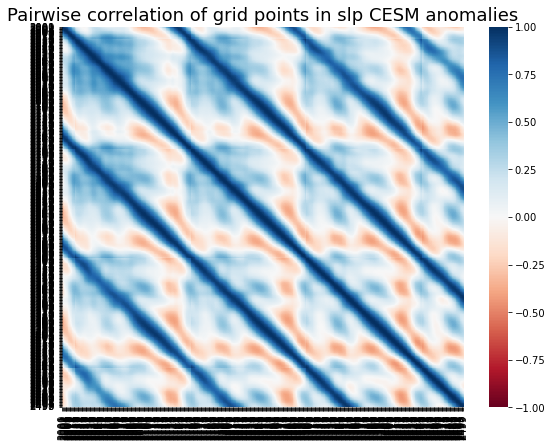

In [39]:
# Plot pairwise correlation coefficients of grid points in slp CESM anomalies:
fig, ax = plt.subplots(figsize=(9,7))
plt.title('Pairwise correlation of grid points in slp CESM anomalies', fontsize=18)
sns.heatmap(
    slp_extract.corr(), 
    cmap="RdBu", 
    xticklabels=True, 
    yticklabels=True,
    center=0,
    vmin=-1,
    vmax=1,
)

In [21]:
# Extract single field, here: Sea level pressure
slp_FOCI = data_FOCI['sea-level-pressure'].values
slp_FOCI.shape

(120, 96, 192)

In [17]:
# Extract single field, here: Sea surface temperature
sst_CESM = data_CESM['sea-surface-temperature'].values
sst_CESM.shape

(120, 96, 144)

In [22]:
# Extract single field, here: Sea surface temperature
sst_FOCI = data_FOCI['sea-surface-temperature'].values
sst_FOCI.shape

(120, 96, 192)

In [7]:
np.sum(np.isnan(sst_CESM))

665760

In [23]:
# Extract ocean mask:
is_over_ocean_CESM = data_CESM['is_over_ocean'].values
is_over_ocean_CESM.shape

(96, 144)

In [25]:
# Extract ocean mask:
is_over_ocean_FOCI = data_FOCI['is_over_ocean'].values
is_over_ocean_FOCI.shape

(96, 192)

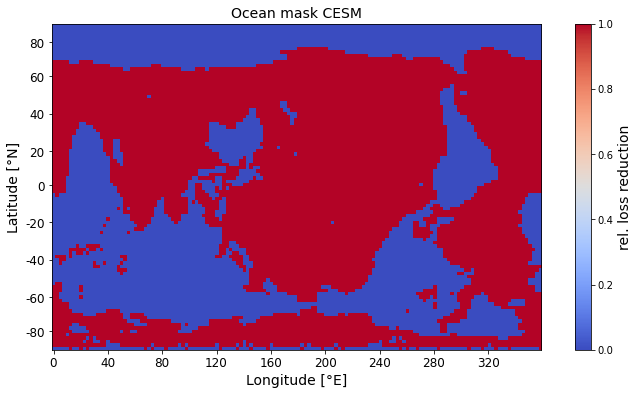

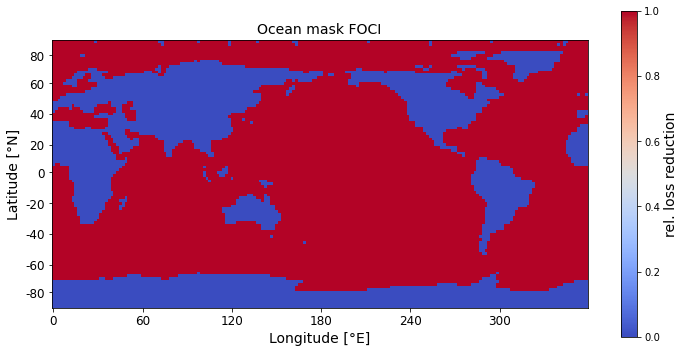

In [27]:
# Plot resulting ocean mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(is_over_ocean_CESM, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Ocean mask CESM', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot resulting ocean mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(is_over_ocean_FOCI, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Ocean mask FOCI', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

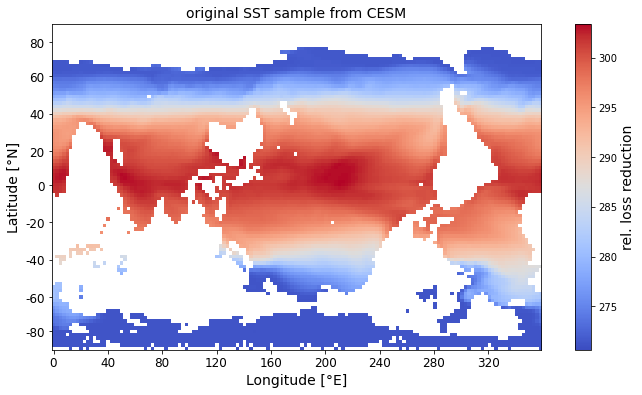

In [33]:
# Plot first SST sample from CESM test data:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(sst_CESM[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('original SST sample from CESM', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

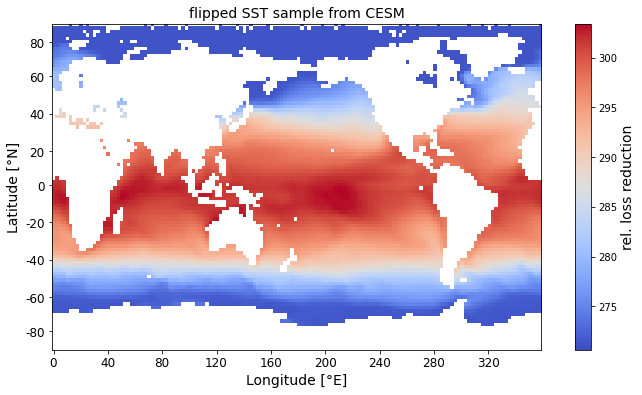

In [32]:
# Plot first SST sample from CESM test data:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(sst_CESM[0], axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('flipped SST sample from CESM', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [62]:
## Derive mask for showing only the continents' silhouette as NaN values, for better orientation in slp fields.

# Initialize storage for silhouette as boolean mask:
land_silhouette_CESM = (np.zeros(is_over_ocean_CESM.shape)!=0)

# Loop over latitude in ocean mask, to scan mask line-by-line:
for i in range(is_over_ocean_CESM.shape[0]):
    
    # Loop over longitude, to scan current line:
    for j in range(is_over_ocean_CESM.shape[1]):
        
        # Check, if current grid point is over land, while previous grid point was over ocean.
        # Take care of initial border:
        if j>0:
            if (is_over_ocean_CESM[i,j]==False) & (is_over_ocean_CESM[i,j-1]==True):
                
                # Set land silhouette:
                land_silhouette_CESM[i,j] = True
                
        # Check, if current grid point is over ocean, while previous grid point was over land.
        # Take care of initial border:
        if j>0:
            if (is_over_ocean_CESM[i,j]==True) & (is_over_ocean_CESM[i,j-1]==False):
                
                # Set land silhouette:
                land_silhouette_CESM[i,j] = True
                
# Loop over longitude in ocean mask, to scan mask row-by-row:
for j in range(is_over_ocean_CESM.shape[1]):
    
    # Loop over latitude, to scan current row:
    for i in range(is_over_ocean_CESM.shape[0]):
        
        # Check, if current grid point is over land, while previous grid point was over ocean.
        # Take care of initial border:
        if i>0:
            if (is_over_ocean_CESM[i,j]==False) & (is_over_ocean_CESM[i-1,j]==True):
                
                # Set land silhouette:
                land_silhouette_CESM[i,j] = True
                
        # Check, if current grid point is over ocean, while previous grid point was over land.
        # Take care of initial border:
        if i>0:
            if (is_over_ocean_CESM[i,j]==True) & (is_over_ocean_CESM[i-1,j]==False):
                
                # Set land silhouette:
                land_silhouette_CESM[i,j] = True
            

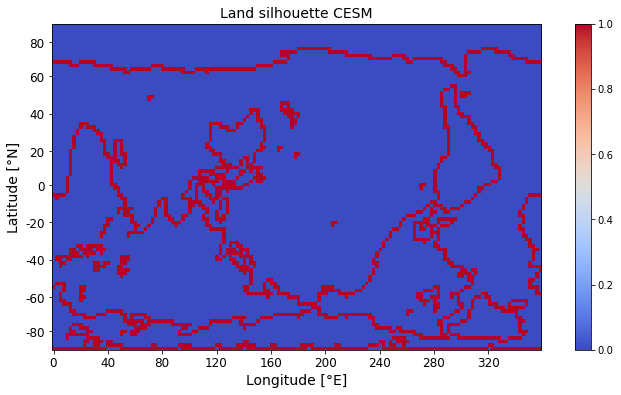

In [69]:
# Plot resulting land silhouette as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(land_silhouette_CESM, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Land silhouette CESM', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [70]:
# Select single feature and compute anomalies, using whole time span as climatology:
data = get_anomalies(feature='sea-level-pressure', data_set=data_CESM) 

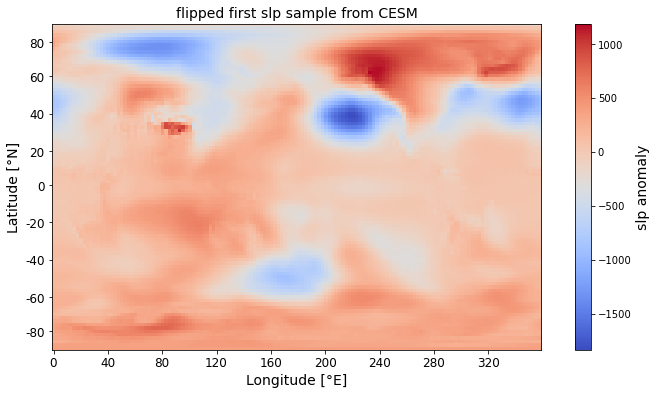

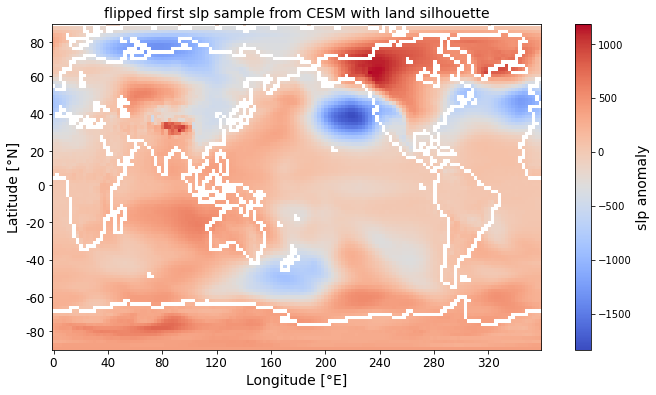

In [71]:
# Extract first sample:
temp_sample = data[0]

# Plot flipped original sample:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(temp_sample,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('slp anomaly', fontsize=14)
plt.title('flipped first slp sample from CESM', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Add land silhouette as NaN values:
temp_sample[land_silhouette_CESM]=float('nan')

# Plot flipped sample with land silhouette:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(temp_sample,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('slp anomaly', fontsize=14)
plt.title('flipped first slp sample from CESM with land silhouette', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [11]:
missing_mask = create_missing_mask(data=data, mask_type='fixed', missing_type='discrete', missing_min=0.9, missing_max=0.9, seed=0)

In [23]:
np.sum(np.isnan(data))

0

In [13]:
np.sum(missing_mask,axis=(1,2))

array([1835, 1835, 1835, ..., 1835, 1835, 1835])

In [14]:
# Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
# Scale or normlalize data according to statistics obtained from only training data.
train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
    data, 
    missing_mask, 
    train_val_split=0.8, 
    scale_to='zero_one'
)

In [24]:
temp_number = np.sum(train_target==0) + np.sum(val_target==0)

In [19]:
np.size(data)*0.9

199065600.0

In [20]:
(np.sum(train_input==0) + np.sum(val_input==0)) - (np.size(data)*0.9)

6734400.0

In [26]:
(np.sum(train_input!=0) + np.sum(val_input!=0)) 

15384000

In [27]:
(np.size(data) - temp_number)*0.1

15538799.9

In [76]:
np.sum(np.isnan(data))

65796000

In [69]:
data[np.isnan(data)]=0

In [71]:
np.max(data)

13.437347

In [ ]:
   

# Extend data, if desired:
data = clone_data(data=data, augmentation_factor=augmentation_factor)

In [ ]:
sst_FOCI[!] = 0

In [36]:
ocean = np.repeat(np.expand_dims(is_over_ocean,axis=0),sst_FOCI.shape[0],axis=0)

In [37]:
sst_FOCI[(ocean==False)]=0

In [38]:
np.sum(np.isnan(sst_FOCI))

0

In [35]:
ocean

(12000, 96, 192)

In [55]:
np.sum(np.isnan(data_FOCI['sea-surface-temperature'].where(data_FOCI["is_over_ocean"]).values))

65796000

In [51]:
np.random.seed(0)
np.random.uniform(low=0, high=1, size=(2,3))

array([[0.5488135 , 0.71518937, 0.60276338],
       [0.54488318, 0.4236548 , 0.64589411]])